3D TV-Regularized Sparse-View CT Reconstruction (ADMM Solver)
=============================================================

This example demonstrates solution of a sparse-view, 3D CT
reconstruction problem with isotropic total variation (TV)
regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - C \mathbf{x}
  \|_2^2 + \lambda \| D \mathbf{x} \|_{2,1} \;,$$

where $C$ is the X-ray transform (the CT forward projection operator),
$\mathbf{y}$ is the sinogram, $D$ is a 3D finite difference operator,
and $\mathbf{x}$ is the desired image.

In this example the problem is solved via ADMM, while proximal
ADMM is used in a [companion example](ct_astra_3d_tv_padmm.rst).

In [1]:
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.examples import create_tangle_phantom
from scico.linop.xray.astra import XRayTransform3D
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image and projector.

In [2]:
Nx = 128
Ny = 256
Nz = 64

tangle = snp.array(create_tangle_phantom(Nx, Ny, Nz))

n_projection = 10  # number of projections
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
C = XRayTransform3D(
    tangle.shape, det_count=[Nz, max(Nx, Ny)], det_spacing=[1.0, 1.0], angles=angles
)  # CT projection operator
y = C @ tangle  # sinogram

Set up problem and solver.

In [3]:
λ = 2e0  # ℓ2,1 norm regularization parameter
ρ = 5e0  # ADMM penalty parameter
maxiter = 25  # number of ADMM iterations
cg_tol = 1e-4  # CG relative tolerance
cg_maxiter = 25  # maximum CG iterations per ADMM iteration

# The append=0 option makes the results of horizontal and vertical
# finite differences the same shape, which is required for the L21Norm,
# which is used so that g(Ax) corresponds to isotropic TV.
D = linop.FiniteDifference(input_shape=tangle.shape, append=0)
g = λ * functional.L21Norm()
f = loss.SquaredL2Loss(y=y, A=C)

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[D],
    rho_list=[ρ],
    x0=C.T(y),
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
    itstat_options={"display": True, "period": 5},
)

Run the solver.

In [4]:
print(f"Solving on {device_info()}\n")
tangle_recon = solver.solve()
hist = solver.itstat_object.history(transpose=True)

print(
    "TV Restruction\nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(tangle, tangle_recon), metric.mae(tangle, tangle_recon))
)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  9.36e+00  1.559e+08  1.098e+03  4.701e+05     25  3.991e-03


   5  4.19e+01  1.861e+05  1.294e+02  5.987e+02     25  1.953e-04


  10  7.20e+01  1.657e+05  4.562e+01  1.051e+02     15  9.501e-05


  15  9.09e+01  1.641e+05  3.663e+01  5.943e+01     19  9.021e-05


  20  1.07e+02  1.632e+05  2.240e+01  3.614e+01      7  9.072e-05


  24  1.14e+02  1.631e+05  1.290e+01  8.143e+00      3  8.961e-05


TV Restruction
SNR: 20.20 (dB), MAE: 0.017


Show the recovered image.

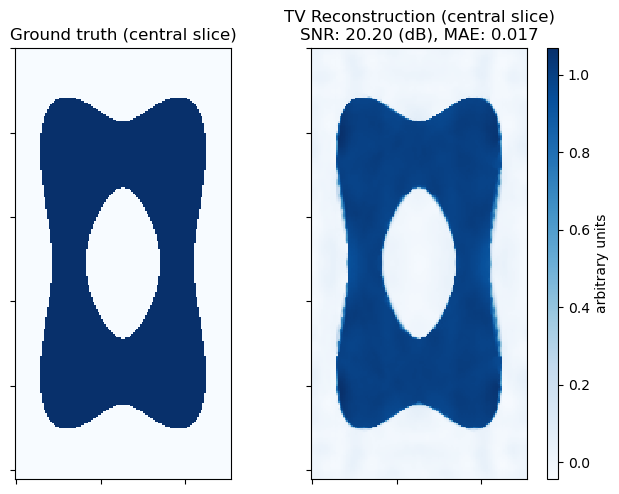

In [5]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(7, 6))
plot.imview(
    tangle[32],
    title="Ground truth (central slice)",
    cmap=plot.cm.Blues,
    cbar=None,
    fig=fig,
    ax=ax[0],
)
plot.imview(
    tangle_recon[32],
    title="TV Reconstruction (central slice)\nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(tangle, tangle_recon), metric.mae(tangle, tangle_recon)),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1],
)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[1].get_images()[0], cax=cax, label="arbitrary units")
fig.show()